In [1]:
#import models
import numpy as np
import h5py
import sys, os
import rospy
import rosbag
import math
from scipy.interpolate import interp1d
import h5py
import matplotlib.pylab as plt
import time 
import cv2 

#sys.path.insert(0, '/media/abdulla/Seagate Expansion Drive/DVS research/DATA/contact estimation/')
from EventPreProcess import EventPreProcess
#from dvs_msgs.msg import EventArray
from std_msgs.msg import Float64, Bool
from geometry_msgs.msg import Pose, Vector3, PoseStamped

In [2]:
#parameters of processing
frequency = 30 #Hz
bag_file_name = '/data/dataset_ENVTACT_new2.bag'
h5_file_name = 'dataset_1_new.hdf5'
time_window_size = 6
examples_per_edge = 1

In [4]:
bag_file = rosbag.Bag(bag_file_name)

events = []
contact_status = []
contact_status_ts = []
contact_case = [] #0:No contact 1: center, 2:remainder of contacts as in list_of_rotations
contact_case_ts = []

contact_case_updated = []
contact_case_updated_ts = []


#generate labels
possible_angle = [0.0174532925, 0.034906585, 0.0523598776, 0.075, 0.095, 0.115, 0.135, 0.15] #[0.075, 0.15]
N_examples = 9
list_of_rotations = [[0, 0, 0]]

for i in range(1, N_examples):
    theta = i * 2 * math.pi/(N_examples - 1)
    for phi in possible_angle:
        rx = phi * math.cos(theta)
        ry = phi * math.sin(theta)
        rotvec = [rx, ry, 0]
        list_of_rotations.append(rotvec)

print(len(list_of_rotations))
print(list_of_rotations)


65
[[0, 0, 0], [0.01234134148078231, 0.012341341480782309, 0], [0.02468268296156462, 0.024682682961564617, 0], [0.03702402451305761, 0.037024024513057606, 0], [0.053033008588991064, 0.05303300858899106, 0], [0.06717514421272203, 0.06717514421272201, 0], [0.08131727983645297, 0.08131727983645295, 0], [0.09545941546018392, 0.09545941546018391, 0], [0.10606601717798213, 0.10606601717798211, 0], [1.0687059397353753e-18, 0.0174532925, 0], [2.1374118794707506e-18, 0.034906585, 0], [3.2061178253293598e-18, 0.0523598776, 0], [4.592425496802574e-18, 0.075, 0], [5.817072295949928e-18, 0.095, 0], [7.04171909509728e-18, 0.115, 0], [8.266365894244634e-18, 0.135, 0], [9.184850993605149e-18, 0.15, 0], [-0.012341341480782309, 0.01234134148078231, 0], [-0.024682682961564617, 0.02468268296156462, 0], [-0.037024024513057606, 0.03702402451305761, 0], [-0.05303300858899106, 0.053033008588991064, 0], [-0.06717514421272201, 0.06717514421272203, 0], [-0.08131727983645295, 0.08131727983645297, 0], [-0.09545941

In [5]:
event_time = np.array([events[i][2] for i in range(np.shape(events)[0])])
def filter_events_by_time(events, time_of_contact, time_period = 0.3e9, threshold=20000):
    event_in_time_idx = np.where((event_time > (time_of_contact - time_period)) * (event_time < time_of_contact))[0]
    #time_of_contact - time_period < ts < time_of_contact

    print(len(event_in_time_idx))
    if len(event_in_time_idx) < threshold:
        return False, []
    else:
        print(event_in_time_idx)
        output_events = np.array(events)[event_in_time_idx,:]
        return True,output_events

In [ ]:
filter(events, )

In [7]:
# def check_contact(events):
#         contact_threshold = 10000 # no. of events 
#         #print("length: ",len(self.new_events_list))
#         if len(events) > contact_threshold:
#             contact_status = True
#         else:
#             contact_status =  False
        
#         return contact_status

In [8]:
gen = bag_file.read_messages(topics=['/contact_status', '/dvs/events', '/contact_angle'])

In [6]:
#parse rosbag
from tqdm.auto import tqdm

for topic, msg, t in tqdm(bag_file.read_messages(topics=['/contact_status', '/dvs/events', '/contact_angle'])):
    if topic == '/dvs/events':
        for e in msg.events:
            event = [e.x, e.y, e.ts.to_nsec(), e.polarity]
            events.append(event)
        event_topic = True    
    elif topic == '/contact_status':
        contact_status.append(msg.data)
        contact_status_ts.append(t.to_nsec())
    elif topic == '/contact_angle':
        #if the first topic is contact angle
        if (len(contact_status) > 1):
            if (contact_status[-1] == True):
                best_rot_diff = 100
                best_rot_idx = 1
                i = 1
                for rot in list_of_rotations:
                    diff_vals = np.sqrt( np.power(rot[0] - msg.x, 2) +  np.power(rot[1] - msg.y, 2) + np.power(rot[2] - msg.z, 2) )
                    if best_rot_diff > diff_vals:
                        best_rot_diff = diff_vals
                        best_rot_idx = i
                    i = i + 1

                contact_case.append(best_rot_idx)
                contact_case_ts.append(t.to_nsec())
            else:
                contact_case.append(0)
                contact_case_ts.append(t.to_nsec())
        else:
            contact_case.append(0)
            contact_case_ts.append(t.to_nsec())
        
        # Updated contact status according to no. of events
        
            
#print(events)
bag_file.close()

/home/hussain/miniconda3/envs/tactile/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
419697it [01:19, 5255.91it/s]


(array([83514.,  7958.,  9944.,  8638.,  9338.,  7464.,  9024.,  7767.,
         9028.,  8570.]),
 array([ 0. ,  6.5, 13. , 19.5, 26. , 32.5, 39. , 45.5, 52. , 58.5, 65. ]),
 <BarContainer object of 10 artists>)

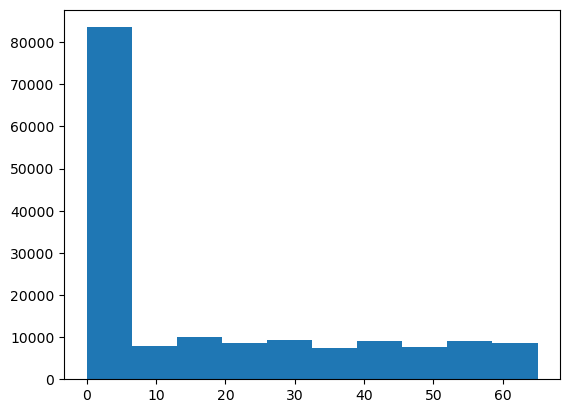

In [22]:
plt.hist(contact_case)

In [24]:
np.unique(contact_case, True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]),
 array([     0,    283,   1456,   2709,   3954,   5206,   6460,   7701,
          8949,  20184,  21431,  22669,  23944,  25205,  26452,  27729,
         29559,  40146,  41395,  42649,  43900,  45199,  46422,  47652,
         50149,  60150,  61401,  62653,  63901,  65156,  66404,  67659,
         69528,  80139,  81387,  82640,  83889,  85142,  86394,  87643,
         89024, 100128, 101380, 102630, 103884, 105134, 106383, 107639,
        108886, 120127, 121380, 122628, 123874, 125124, 126376, 127625,
        130127, 140116,   1452,   2702,   3940,   5193,   6447,   7696,
         10198, 160071]))

In [8]:
#interpolate
f = interp1d(contact_case_ts, contact_case, kind='previous')
contact_case_ts_int = range(min(contact_case_ts), max(contact_case_ts), int(1e9/frequency))
contact_case_int = f(contact_case_ts_int)

In [9]:
1e9/frequency

33333333.333333332

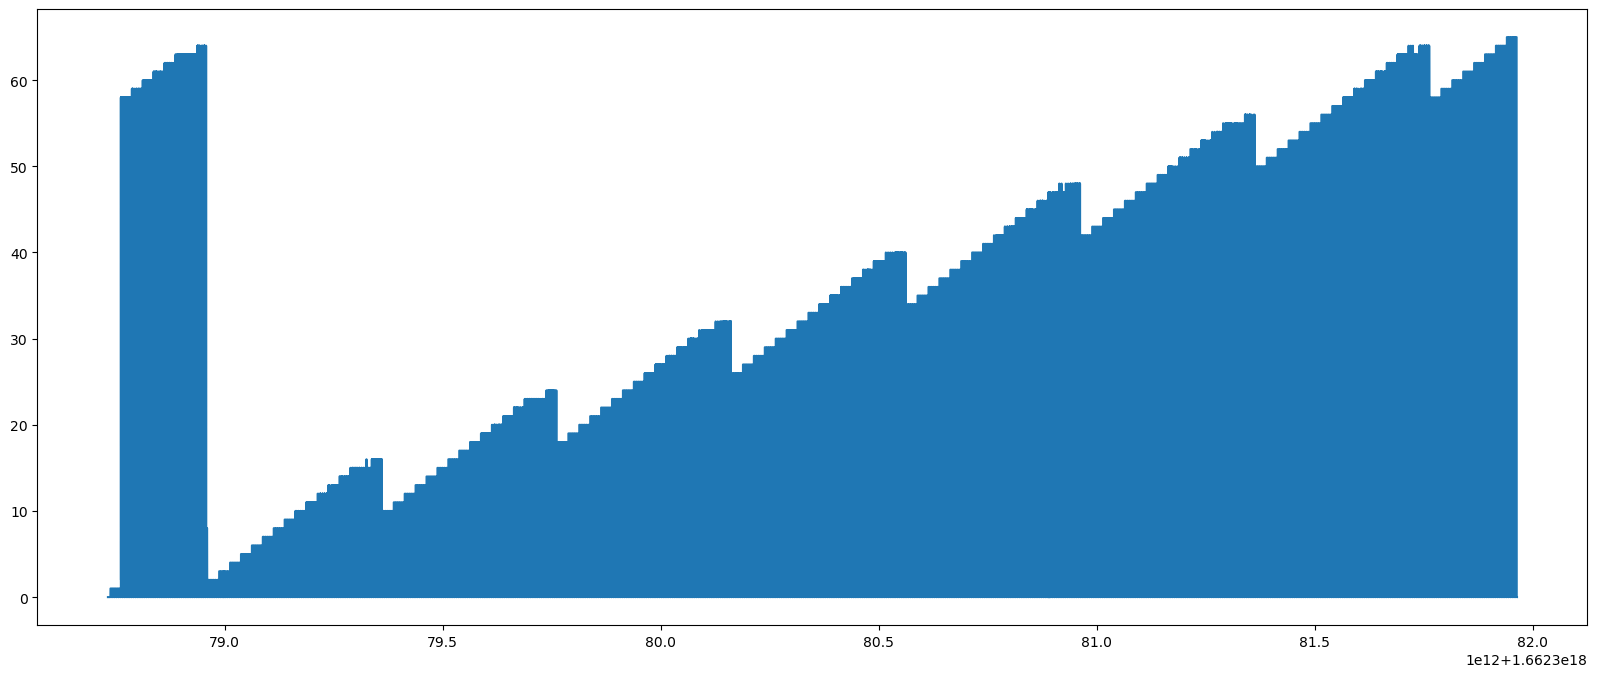

96927


In [10]:
plt.figure(figsize=(20,8))
plt.plot(contact_case_ts, contact_case)
plt.show()
print(len(contact_case_ts_int))

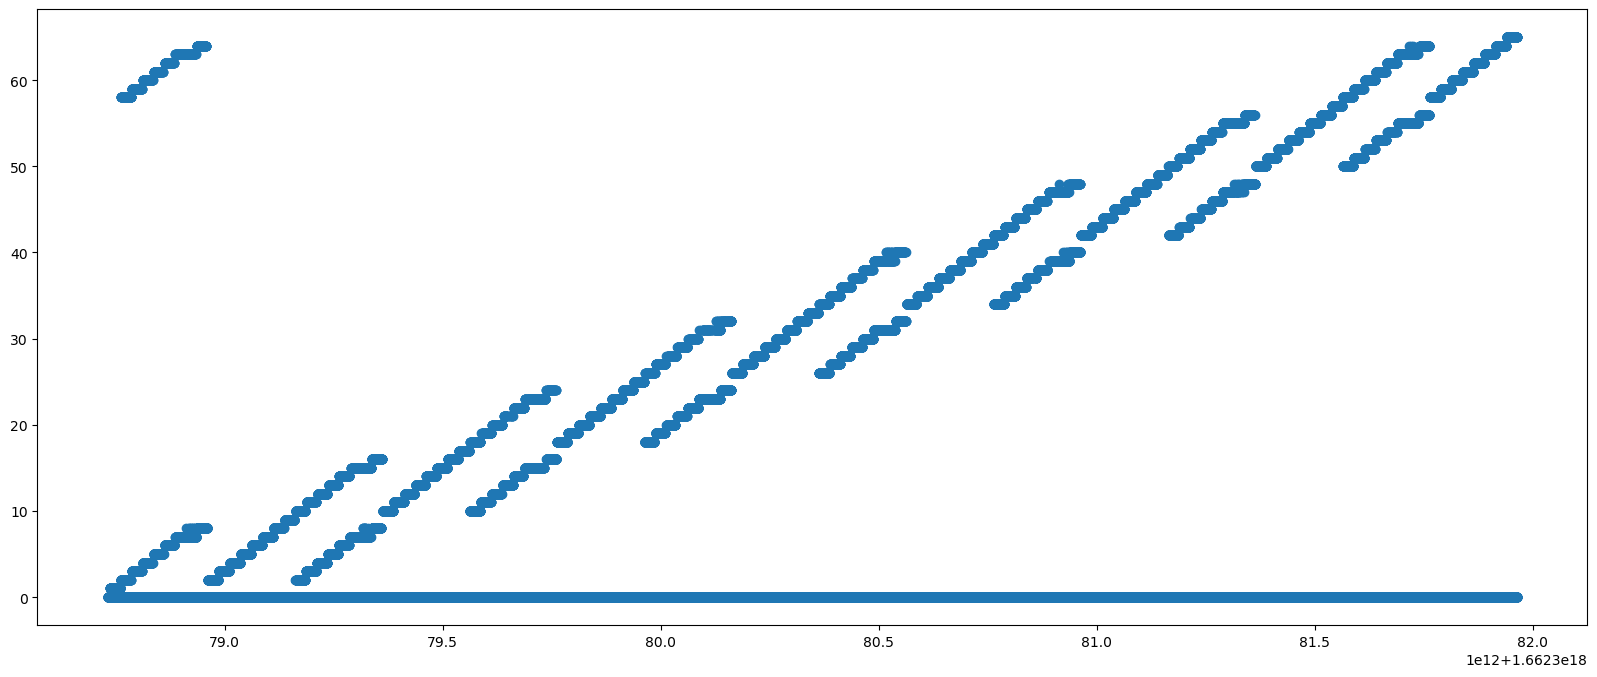

96927


In [11]:
plt.figure(figsize=(20,8))
plt.scatter(contact_case_ts_int, contact_case_int)
plt.show()
print(len(contact_case_ts_int))

In [31]:
contact_rise_idx.shape

(2376,)

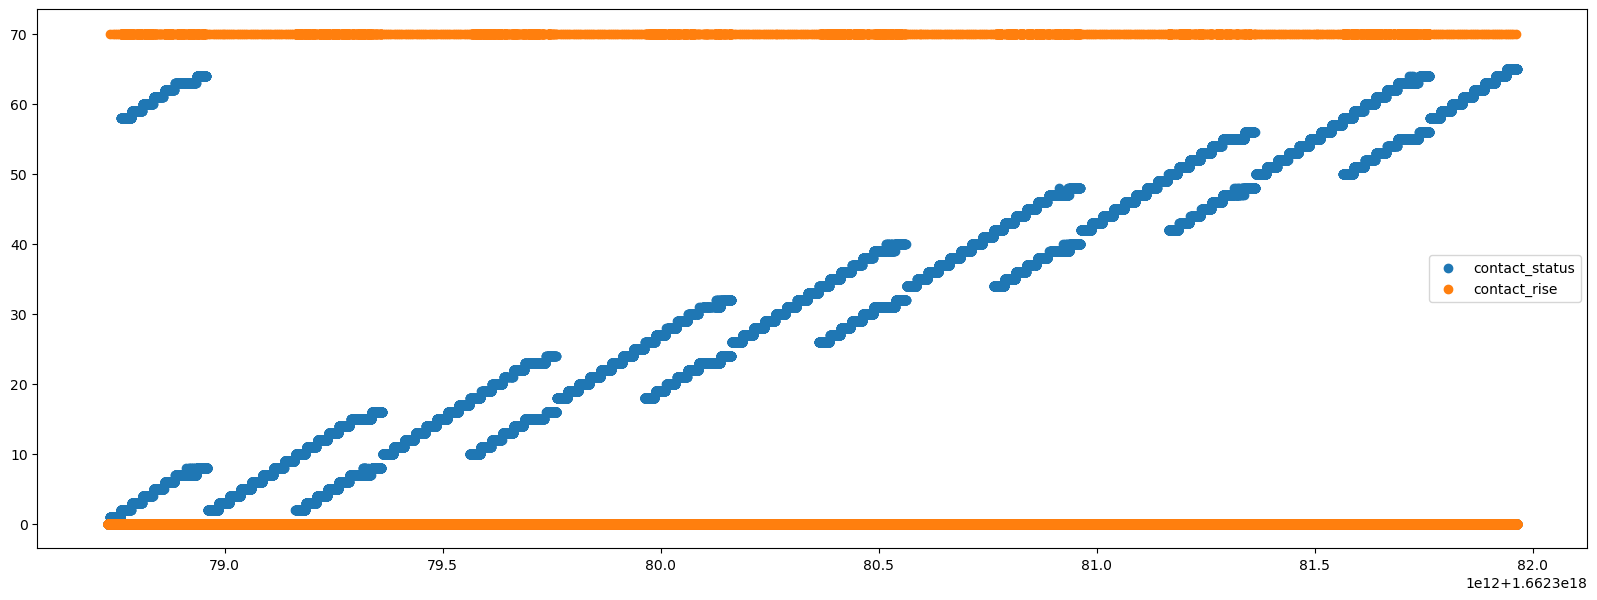

In [14]:
#from scipy import signal
#find the rising peak
# contact_peaks_idx, contact_peak_magnitude = signal.find_peaks(contact_case_int, height=0.4, distance=30)
contact_case_diff_int = np.diff(contact_case_int)
contact_case_diff_int = np.insert(contact_case_diff_int, 0, 0)
contact_rise_idx = np.where(contact_case_diff_int > 0.4)[0]

contact_rise_int = [0 for i in range(len(contact_case_int))]
for index in contact_rise_idx:
    contact_rise_int[index] = 70

#cont_rise_int = 20 if there is an event

plt.figure(figsize=(20,7))
plt.scatter(contact_case_ts_int, contact_case_int)
plt.scatter(contact_case_ts_int, contact_rise_int)
plt.legend(['contact_status', 'contact_rise'])
plt.show()

In [22]:
def generateFrames(event_list, time_steps, im_height=260, im_width=346, im_channel=3, time_window=None):
        event_iterator = 0
        channel = 0
        x = [0, 0, 0]
        event_image = np.zeros((im_height, im_width, im_channel), dtype=np.float32)
        for ts in time_steps:
            
            for i in range(event_iterator, len(event_list)):
                event_iterator = i + 1
                event = np.copy(event_list[i]) #[x, y, ts, polarity]
                if (time_window==None) or (event[2] > ts - time_window):
                    if event[2] > ts:
                        event_image[201, 154, 0] = 0
                        channel = channel + 1
                        #print("cahnnel = ", channel)
                        break
                    else:
                        # print("ha")
                        x[channel] = x[channel] + 1
                        if event[3] > 0:
                            event_image[int(event[1]), int(event[0]), channel] = event_image[int(event[1]), int(event[0]), channel] + 1.0
                        else:
                            event_image[int(event[1]), int(event[0]), channel] = event_image[int(event[1]), int(event[0]), channel] - 1.0             
        
        return event_image

In [23]:
def cropFrames(image, circle_center=(173, 130), circle_rad=100, im_height=260, im_width=346, im_channels=3):
        mask = np.zeros((im_height, im_width, im_channels), dtype=np.float32)            
        cv2.circle(mask, circle_center, circle_rad, [1]*im_channels, -1, 8, 0)
        cropped_image = np.multiply(mask, image)

        return cropped_image

In [24]:

label_contact_case = np.array(contact_case_int)[contact_rise_idx+1]
print(label_contact_case)

[ 1.  1.  1. ... 17. 17. 17.]


In [16]:
t_ = 1662378738061692640
filter_events_by_time(events, t_)

210


(False, [])

In [20]:
t_ - 0.3e9

1.6623787377616927e+18

In [19]:
event_time = np.array([events[i][2] for i in range(np.shape(events)[0])])

In [31]:
np.array(events)[:, 2]

array([1662378732593736638, 1662378732595119638, 1662378732595269638, ...,
       1662381972813252638, 1662381972813365638, 1662381972813477638])

In [33]:
(event_time == np.array(events)[:, 2]).all()

True

In [41]:
np.where([1, 0, 0, 1, 10, 0, 0,1])[0]

array([0, 3, 4, 7])

In [25]:
contact_rise_idx

array([  170,   319,   472, ..., 96521, 96671, 96823])

In [15]:
hf = h5py.File(h5_file_name, 'w')
#find events that satisfy time
label_contact_case = []
i=0
for status_index in tqdm(contact_rise_idx[:1000]):
    event_frames_list = []
    for j in range(-7, 8): #at peak look at a radius of 7 around the event 
        time_step = contact_case_ts_int[ status_index + j ]
        print(time_step)
        detect, event_array = filter_events_by_time(events, time_step)
        if detect:
            frame_time_steps = [time_step-0.2e9, time_step-0.1e9, time_step]
            event_frame = generateFrames(event_array, frame_time_steps)
            cropped_image = cropFrames(event_frame)
            event_frames_list.append(cropped_image)
            label_contact_case.append(np.array(contact_case_int)[status_index+1])
            if not ('contact_status' in hf.keys()):
                hf.create_dataset('contact_status', data=label_contact_case, maxshape=(None,))
                hf.create_dataset('event_images', data=event_frames_list, maxshape=(None,None, None, None))
            else:
                hf['contact_status'].resize(len(hf['contact_status']) + 1, axis=0)
                hf["contact_status"][-len(label_contact_case):] = label_contact_case
                hf['event_images'].resize(len(hf['event_images']) + len(event_frames_list), axis=0)
                hf["event_images"][-len(event_frames_list):] = event_frames_list 
            break # break if event has been detected already within radius 7

    i = i + 1
    
hf.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

1662378738061692640
210
1662378738095025973
254
1662378738128359306
611
1662378738161692639
664
1662378738195025972
685
1662378738228359305


  0%|          | 0/1000 [00:40<?, ?it/s]

817
1662378738261692638


KeyboardInterrupt: 

In [27]:
#visualize example
# plot the sample image
hf = h5py.File(h5_file_name, 'r+')
print(len(hf['event_images']))
fig=plt.figure(figsize=(20, 20))
rows = 5
columns = 6
for i in range(0, 30):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(hf['event_images'][i][:,:,2])
plt.show()
hf.close()

KeyError: "Unable to open object (object 'event_images' doesn't exist)"

In [ ]:

# event_times = np.array([events[i][2] for i in range(np.shape(events)[0])])
# threshold = 10000
# plt.plot(event_times)
# plt.show()
# print(contact_case_ts_int[ contact_rise_idx[0] ])
# event_in_time_idx = np.where((event_times > (contact_case_ts_int[ contact_rise_idx[0] ] - 0.3)) * (event_times < contact_case_ts_int[ contact_rise_idx[0] ] ))
# print(len(event_in_time_idx))
# if len(event_in_time_idx) < threshold:
#     print("ok")
# else:
#     output_events = events[event_in_time_idx][:]
#     print("why")

In [ ]:
del EventPreProcess
from importlib import reload  
import EventPreProcess
reload(EventPreProcess)
from EventPreProcess import EventPreProcess

In [ ]:
#Generate frames, crop and and store in h5 file
#hf.close()
hf = h5py.File(h5_file_name, 'w')
hf.create_dataset('contact_status', data=contact_case_int)
hf.create_dataset('time_steps', data=contact_case_ts_int)

set_size = 1000
unprocessed_events = np.copy(events)
# print(len(contact_case_int))
# print(contact_case_ts_int)
# desired_status = 12
# encounter = np.min(np.nonzero([i == desired_status for i in hf['contact_status']]))#searches for the desired status
# print(encounter)

for i in range(0, len(contact_case_ts_int), set_size):
    start_idx=i
    end_idx=min([len(contact_case_ts_int), i+set_size])
    #[event_frames, unprocessed_events] = EventPreProcess.ConcatenateEvents(unprocessed_events, contact_case_ts_int[start_idx:end_idx])

    #[event_frames, unprocessed_events] = EventPreProcess.generateFrames_temporalROI(unprocessed_events, contact_case_ts_int[start_idx:end_idx])
    [event_frames, unprocessed_events] = EventPreProcess.generateFrames(unprocessed_events, contact_case_ts_int[start_idx:end_idx])
    
    #print("event frames shape : ", np.shape(event_frames))
    cropped_image = EventPreProcess.cropFrames(event_frames, circle_center=(170, 125), circle_rad=115)
    #print("length cropped iamges : ", len(cropped_image))
    
    #write data
    if i==0:
        hf.create_dataset('event_images', data=cropped_image, maxshape=(None,None, None, None))
    else:
        hf['event_images'].resize(len(hf['event_images']) + len(cropped_image), axis=0)
        hf["event_images"][-len(cropped_image):] = cropped_image 

    
    del event_frames

hf.close()

In [ ]:
# hf = h5py.File(h5_file_name, 'r+')
# desired_status = 13
# encounter = np.min(np.nonzero([i == desired_status for i in hf['contact_status']]))#searches for the desired status
# print(encounter)
# print("time of contact = ", (hf['time_steps'][encounter]/1e9))

# original_image = hf['event_images'][encounter]
# original_contact_status = hf['contact_status'][encounter]
# rot_90_image = EventPreProcess.rotateFrames([original_image], circle_center=(170, 125), rotate_angle=90)
# rot_90_contact_status = EventPreProcess.updateContactStatus([original_contact_status], list_of_rotations, 90)

# plt.imshow(original_image[:,:,0])
# plt.show()
# print(original_contact_status)
# print(rot_90_contact_status)
# plt.imshow(rot_90_image[0])
# plt.show()
# hf.close()

In [ ]:
hf = h5py.File(h5_file_name, 'r+')
print(hf['contact_status'].shape)
print(hf['event_images'].shape)
hf.close()


(15241,)
(15241, 260, 346, 1)


In [ ]:
def rotateFrames(image_list, circle_center=(173, 130), rotate_angle=90, im_height=260, im_width=346, expand_dims=False):
        
        rotated_image_list = []

        for image in image_list:
            rot_mat = cv2.getRotationMatrix2D(circle_center, rotate_angle, 1.0)
            #rotated_image = cv2.warpAffine(image[:,:,0], rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
            rotated_image = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)

            if expand_dims:
                rotated_image_list.append(np.expand_dims(np.copy(rotated_image), axis=2)) 
            else:
                rotated_image_list.append(np.copy(rotated_image))

        return rotated_image_list


In [ ]:
hf.close()

In [ ]:
#Augment images with rotation
hf = h5py.File(h5_file_name, 'r+')
set_size = 10

for i in range(0, len(hf['event_images']), set_size):
    start_idx=i
    end_idx=min([len(hf['event_images']), i+set_size])

    original_image = hf['event_images'][start_idx:end_idx]
    original_contact_status = hf['contact_status'][start_idx:end_idx]

    rot_90_image = rotateFrames(original_image, circle_center=(170, 125), rotate_angle=90, expand_dims=False)
    rot_90_contact_status = EventPreProcess.updateContactStatus(original_contact_status, list_of_rotations, 90)

    rot_180_image = rotateFrames(original_image, circle_center=(170, 125), rotate_angle=180, expand_dims=False)
    rot_180_contact_status = EventPreProcess.updateContactStatus(original_contact_status, list_of_rotations, 180)

    rot_270_image = rotateFrames(original_image, circle_center=(170, 125), rotate_angle=270, expand_dims=False)
    rot_270_contact_status = EventPreProcess.updateContactStatus(original_contact_status, list_of_rotations, 270)

    print(original_image.shape)
    print(len(rot_90_image)
    print(rot_90_image[1].shape)

    #write data
    if i==0:
        hf.create_dataset('event_images_augmented', data=np.concatenate((original_image, rot_90_image, rot_180_image, rot_270_image), axis=0), maxshape=(None,None, None, None))
        hf.create_dataset('contact_status_augmented', data=np.concatenate((original_contact_status, rot_90_contact_status, rot_180_contact_status, rot_270_contact_status), axis=0), maxshape=(None,))
    else:
        hf['event_images_augmented'].resize(len(hf['event_images_augmented']) + 4*len(original_image), axis=0)
        hf["event_images_augmented"][-4*len(original_image):] = np.concatenate((original_image, rot_90_image, rot_180_image, rot_270_image), axis=0)

        hf['contact_status_augmented'].resize(len(hf['contact_status_augmented']) + 4*len(original_contact_status), axis=0)
        hf["contact_status_augmented"][-4*len(original_contact_status):] = np.concatenate((original_contact_status, rot_90_contact_status, rot_180_contact_status, rot_270_contact_status), axis=0)

hf.close()

(10, 260, 346, 1)
(260, 346)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 4 dimension(s) and the array at index 1 has 3 dimension(s)

In [ ]:
hf.close()

In [ ]:
print(np.array(list_of_rotations[2][0:2]))
rotation_angle = 90
rot_mat = np.array( [ [math.cos(rotation_angle*math.pi/180), math.sin(rotation_angle*math.pi/180)], [-math.sin(rotation_angle*math.pi/180), math.cos(rotation_angle*math.pi/180)] ] )
print(rot_mat)
print(np.matmul(rot_mat, list_of_rotations[2][0:2] ))

[0.10606602 0.10606602]
[[ 6.123234e-17  1.000000e+00]
 [-1.000000e+00  6.123234e-17]]
[ 0.10606602 -0.10606602]


In [ ]:
hf = h5py.File(h5_file_name, 'r+')
print('number of event images: {}'.format(len(hf['contact_status_augmented'])))
hf.close()

number of event images: 316


In [ ]:
hf = h5py.File(h5_file_name, 'r+')
n_classes = 18
for i in range(len(hf['contact_status_augmented'])):
    one_hot_vector = [0] * n_classes
    one_hot_vector[int(hf['contact_status_augmented'][i])] = 1
    if not ('ex_input_image_idx' in hf.keys()):
        hf.create_dataset('ex_input_image_idx', data=[i], maxshape=(None,))
        hf.create_dataset('ex_output', data=[one_hot_vector], maxshape=(None, None))
    else:
        hf['ex_input_image_idx'].resize(len(hf['ex_input_image_idx']) + 1, axis=0)
        hf["ex_input_image_idx"][len(hf['ex_input_image_idx'])-1] = i

        hf['ex_output'].resize(len(hf['ex_output']) + 1, axis=0)
        hf["ex_output"][len(hf['ex_output'])-1] = one_hot_vector

hf.close()

                

In [ ]:
hf = h5py.File(h5_file_name, 'r+')
print(hf['ex_input_image_idx'].shape)
print(hf['ex_output'].shape)
hf.close()

(316,)
(316, 18)


20


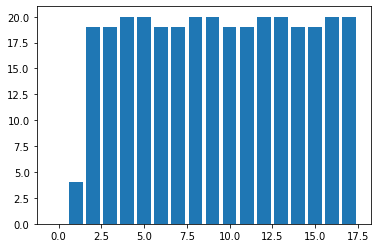

In [ ]:
#analyze classes
hf = h5py.File(h5_file_name, 'r+')
counter = [0] * 18

for i in range(len(hf['ex_output'])):
    idx = list(hf['ex_output'][i]).index(1)
    counter[idx] = counter[idx] + 1

print(counter[17])
plt.bar(range(0,18),counter)#18),counter)
hf.close()

In [ ]:
hf = h5py.File(h5_file_name, 'r+')
print(hf['ex_input_image_idx'].shape)
hf.close()

(340,)


In [ ]:
#Equalize representation of classes (Just to match the names of the dataset with the older version)
hf = h5py.File(h5_file_name, 'r+')
hf.create_dataset('ex_input_image_idx_equalized', data=hf['ex_input_image_idx'])
hf.create_dataset('ex_output_equalized', data=hf['ex_output'])
hf.close()

316
[0, 4, 19, 19, 20, 20, 19, 19, 20, 20, 19, 19, 20, 20, 19, 19, 20, 20]


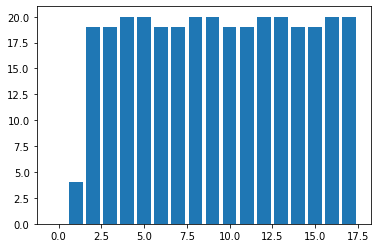

In [ ]:
hf = h5py.File(h5_file_name, 'r+')
new_counter = [0] * 18
print(len(hf['ex_input_image_idx_equalized']))
for i in range(len(hf['ex_output_equalized'])):
    idx = list(hf['ex_output_equalized'][i]).index(1)
    new_counter[idx] = new_counter[idx] + 1

print(new_counter)
plt.bar(range(0,18),new_counter)
hf.close()

[4507, 4567, 4628, 4688, 4748]


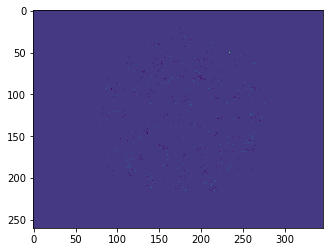

[1904, 1965, 5025, 5084, 5145, 10105, 10165, 10226, 10286, 10345, 15306, 15367, 15426, 15487, 15546, 16507, 16567, 16628, 16688, 16748]


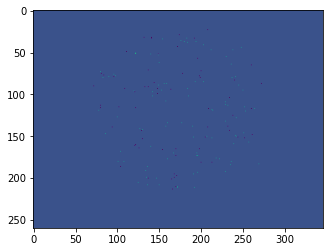

In [ ]:
#compare augmented data with regular images
hf = h5py.File(h5_file_name, 'r')
desired_class = 16
idx = 0
increment = 2

edge_locations = np.where(np.multiply(np.diff(hf['contact_status'])>0, np.equal(np.array(hf['contact_status']), desired_class * np.ones(shape=np.shape(hf['contact_status'])))[1:] ))
edge_locations = np.array(edge_locations)[0].tolist()
print(edge_locations)

plt.imshow(hf['event_images'][edge_locations[idx]+increment][:,:,0])
plt.show()

idx = 2

edge_locations_augmented = np.where(np.multiply(np.diff(hf['contact_status_augmented'])>0, np.equal(np.array(hf['contact_status_augmented']), desired_class * np.ones(shape=np.shape(hf['contact_status_augmented'])))[1:] ))
edge_locations_augmented = np.array(edge_locations_augmented)[0].tolist()
print(edge_locations_augmented)

plt.imshow(hf['event_images_augmented'][edge_locations_augmented[idx]+increment][:,:,0])
plt.show()

hf.close()

In [ ]:
hf = h5py.File(h5_file_name, 'r+')
del hf['ex_input_image_idx'] 
del hf['ex_output']
hf.close()

In [ ]:
print(np.mean(hf['event_images'][:,:,:,0]))
print(np.std(hf['event_images'][:,:,:,0]))
print(np.max(hf['event_images'][:,:,:,0]))
print(np.min(hf['event_images'][:,:,:,0]))


0.0008835273
0.031460017
21.0
0.0


(260, 346, 3)
4.0
-9.0


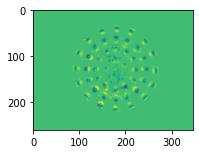

In [ ]:
from PIL import Image
import h5py
import matplotlib.pylab as plt
import numpy as np
np.set_printoptions(threshold=np.inf)
h5_file_name = 'dataset_1_new.hdf5'
hf = h5py.File(h5_file_name, 'r')
print(hf['event_images_augmented'][0].shape)
fig=plt.figure(figsize=(20, 20))
rows = 5
columns = 6
for i in range(0, 1):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(hf['event_images_augmented'][0][:,:,2])
    
    #print(hf['event_images_augmented'][0][:,:,2])
    im = Image.fromarray(hf['event_images_augmented'][0][:,:,2])
    if im.mode != 'RGB':
        im = im.convert('RGB')
    print(np.max(hf['event_images_augmented'][0][:,:,2]))
    print(np.min(hf['event_images_augmented'][0][:,:,2]))
    im.save("preprocess_frame.png")
plt.show()
hf.close()